# PowerX strategy with takeprofit & stoploss
This is an extension of the initial Freqtrade PowerX strategy (inspired by Marcus Heitkotter). Th original strategy had no takeprofit or stoploss, based on R:R 1:1,5 but based on the Freqtrade ROI and SL and also exit signals based on indicators.

### Extra informatie
Dit notebook bevat de volgende handige trucs:
* MACD, RSI, SMA, STOCH indicatoren van ta-lib
* een functie waarmee eenvoudig buy/sell signalen kunnen worden gegenereerd vanuit de freqtrade indicator functie
* custom takeprofit en stoploss levels, bepaald op de dan geldende prijs (- of + een atr factor)
* takeprofit en stoploss levels die over meerdere rijen (rows) hetzelfde blijven zodat ze eigenlijk een lijn vormen voor stoploss of takeprofit
* maken van een graph die toont hoe de strategie theoretisch gesproken zou kunnen werken

In [137]:
# Load libraries
import pandas as pd
import pandas_ta as pta
import talib.abstract as ta
from pandas import DataFrame
import numpy as np
import mplfinance as mpf

In [138]:
# Load data from Binance downloaded by Freqtrade
df = pd.read_json("./data/BTC_USDT-1d.json")
df.columns=['date','open','high','low','close','volume']
df['date']=(pd.to_datetime(df['date'],unit='ms'))
# df = df.set_index(pd.DatetimeIndex(df['date'].values)) # Make date the index
# df.index.name = 'Date' # Rename index to Date
df.reset_index(drop=True, inplace=True)
df.tail(5)

,date,open,high,low,close,volume
1593,2021-12-27,50775.48,52088.00,50449.00,50701.44,28779.58212
1594,2021-12-28,50701.44,50704.05,47313.01,47543.74,45853.33924
1595,2021-12-29,47543.74,48139.08,46096.99,46464.66,39498.87000
1596,2021-12-30,46464.66,47900.00,45900.00,47120.87,30352.29569
1597,2021-12-31,47120.88,48548.26,45678.00,46216.93,34937.99796


In [139]:
df.shape

(1598, 6)

In [156]:
# Plot the close price
# mpf.plot(df)

In [158]:
# Use MPF to plot the last 90 days with style and volume, also include two moving averages
# mpf.plot(df[-90::],title='Bitcoin Prices', type='candle', style='charles', mav=(21,50),volume=True,show_nontrading=True)

In [141]:
# Add indicators
# RSI
df['rsi'] = ta.RSI(df, timeperiod=14)
# STOCHASTICS
stoch = ta.STOCH(
    df,
    fastk_period=14,
    slowk_period=3,
    slowk_matype=0,
    slowd_period=3,
    slowd_matype=0,
)
df['slowd'] = stoch['slowd']
df['slowk'] = stoch['slowk']
# MACD
macd = ta.MACD(
        df,
        fastperiod=12,
        fastmatype=0,
        slowperiod=26,
        slowmatype=0,
        signalperiod=9,
        signalmatype=0,
    )
df["macd"] = macd["macd"]
df["macdsignal"] = macd["macdsignal"]
df["macdhist"] = macd["macdhist"]
# ATR
df['atr'] = ta.ATR(df, timeperiod=14)

In [142]:
# Calculate the ATR stoploss and TakeProfit pricetargets per candle (with multipliers)
# atr_sl_mult = 1
# atr_tp_mult = 2

# df['stoploss'] = df['close'] - (df['atr'] * atr_sl_mult)
# df['takeprofit'] = df['close'] + (df['atr'] * atr_tp_mult)
# df.drop(columns=['stoploss','takeprofit'])

In [143]:
df.tail(5)

,date,open,high,low,close,volume,rsi,slowd,slowk,macd,macdsignal,macdhist,atr
1593,2021-12-27,50775.48,52088.00,50449.00,50701.44,28779.58212,50.241134,82.191316,80.205182,-882.716400,-1646.006689,763.290290,2469.152594
1594,2021-12-28,50701.44,50704.05,47313.01,47543.74,45853.33924,40.655289,75.649879,64.763813,-985.644614,-1513.934274,528.289660,2535.001694
1595,2021-12-29,47543.74,48139.08,46096.99,46464.66,39498.87000,37.987915,62.298739,41.927222,-1141.134415,-1439.374303,298.239887,2499.793716
1596,2021-12-30,46464.66,47900.00,45900.00,47120.87,30352.29569,40.542652,43.540608,23.930790,-1197.605292,-1391.020501,193.415208,2464.094165
1597,2021-12-31,47120.88,48548.26,45678.00,46216.93,34937.99796,38.207577,27.640997,17.064979,-1300.310107,-1372.878422,72.568315,2493.106010


## Signalen bepalen
Met behulp van onderstaande functie kan bepaald worden of er een buy of sell signaal gegeven moet worden door de strategy. Het signaal van de strategie voor buy signalen wordt dus eigenlijk op deze plek gegeven en niet in de Freqtrade buy_signal functie. Deze laatste krijgt uiteindelijk een soort extract hiervan uit de strategie...

In [144]:
def buy_sell(data):
    rsi_level = 50
    slowd_level = 50
    
    signal = []
    
    for i in range(len(df)):
        """
        This is the place where the actual strategic buy signal should be given
        A sell signal based on indicators can be added with a elif statement and neutral conditions
        can be given by the else statements.
        These signals can also be given by the qtpylib crossover functions but thats more for
        the Freqtrade bot itself.
        """
        if (df['rsi'][i] > rsi_level) & (df['slowd'][i] > slowd_level) & (df['macd'][i] > df['macdsignal'][i]):
            signal.append('buy')
        else:
            signal.append('sell')
    
    return signal

In [145]:
# signal = buy_sell(df)
df['signal'] = buy_sell(df)

In [146]:
df[['date','open','close','rsi','slowd','macdhist','signal']][df['signal']=='sell'].tail(25)

,date,open,close,rsi,slowd,macdhist,signal
1569,2021-12-03,56484.26,53601.05,38.415831,45.573259,-285.015222,sell
1570,2021-12-04,53601.05,49152.47,31.476679,42.008704,-632.301829,sell
1571,2021-12-05,49152.46,49396.33,32.199668,37.425393,-789.462399,sell
1572,2021-12-06,49396.32,50441.92,35.349386,38.437320,-766.253154,sell
1573,2021-12-07,50441.91,50588.95,35.801031,41.771801,-686.805827,sell
1574,2021-12-08,50588.95,50471.19,35.586600,46.382262,-591.607227,sell
1575,2021-12-09,50471.19,47545.59,30.671535,46.354182,-669.367901,sell
1576,2021-12-10,47535.90,47140.54,30.052658,43.089099,-689.078515,sell
1577,2021-12-11,47140.54,49389.99,37.584688,38.495868,-500.396676,sell
1578,2021-12-12,49389.99,50053.90,39.650230,37.329096,-291.034452,sell


In [147]:
df[['date','open','close','rsi','slowd','macdhist','signal']][df['signal']=='buy'].tail(25)

,date,open,close,rsi,slowd,macdhist,signal
1511,2021-10-06,51471.99,55315.00,70.593417,94.374944,1265.166129,buy
1512,2021-10-07,55315.00,53785.22,65.804378,94.808331,1303.727940,buy
1513,2021-10-08,53785.22,53951.43,66.073676,93.425352,1266.814018,buy
1514,2021-10-09,53955.67,54949.72,67.718074,90.664554,1234.742536,buy
1515,2021-10-10,54949.72,54659.00,66.704103,89.114940,1122.311605,buy
1516,2021-10-11,54659.01,57471.35,71.197103,90.030060,1160.879447,buy
1517,2021-10-12,57471.35,55996.93,66.156800,91.091830,1015.851079,buy
1518,2021-10-13,55996.91,57367.00,68.395757,93.060485,942.564167,buy
1519,2021-10-14,57370.83,57347.94,68.328034,93.089016,827.285904,buy
1520,2021-10-15,57347.94,61672.42,74.497957,93.807789,967.040377,buy


Wanneer een instapsignaal aanwezig is, controleer dan of dit een verandering is ten opzichte van de vorige candle:

In [152]:
df['advice_changed'] = df['signal'].shift(+1) != df['signal']
df[['advice_changed','signal','close']][df['advice_changed']==True].tail(10)

,advice_changed,signal,close
1481,True,buy,52663.90
1482,True,sell,46863.73
1507,True,buy,47634.90
1529,True,sell,60852.22
1545,True,buy,66947.66
1548,True,sell,64122.23
1589,True,buy,50838.81
1591,True,sell,50399.66
1592,True,buy,50775.49
1594,True,sell,47543.74


Onderstaande code checked op veranderd advice (advice changed = True) en buy signalen (signal = buy). Indien ja, dan worden stoploss en takeprofit points berekend. Zolang er geen sell signaal is (elif advice changed is sell), dan wordt de waarde van de voorgaande cell overgenomen (df.loc[i-1, 'stoploss']) zodat dit een grens wordt waaronder of boven de 'close' prijs moet komen om een sell signaal te triggeren.
Is het veranderde advies 'sell' vanuit de strategie gezien, dan zal er geen waarde meer worden opgeslagen (np.nan). Zolang er geen verandering zal plaatsvinden zal deze waarde ook overgenomen worden van de voorgaande cel.

In [183]:
atr_sl_mult = 1
atr_tp_mult = 2

for i, row in df.iterrows():
    if row['advice_changed'] == True and row['signal'] == 'buy':
        df.loc[i,'takeprofit'] = row['close'] + (row['atr'] * atr_tp_mult)
        df.loc[i,'stoploss'] = row['close'] - (row['atr'] * atr_sl_mult)
        df.loc[i,'buyprice'] = row['close']
    elif row['advice_changed'] == True and row['signal'] == 'sell':
        df.loc[i,'takeprofit'] = np.nan
        df.loc[i,'stoploss'] = np.nan
        df.loc[i,'buyprice'] = np.nan
    else:
        df.loc[i,'takeprofit'] = df.loc[i-1,'takeprofit']
        df.loc[i,'stoploss'] = df.loc[i-1,'stoploss']
        df.loc[i,'buyprice'] = df.loc[i-1,'buyprice']

df[['advice_changed','signal','close','buyprice','takeprofit','stoploss']].tail(50)

,advice_changed,signal,close,buyprice,takeprofit,stoploss
1548,True,sell,64122.23,NaN,NaN,NaN
1549,False,sell,64380.00,NaN,NaN,NaN
1550,False,sell,65519.10,NaN,NaN,NaN
1551,False,sell,63606.74,NaN,NaN,NaN
1552,False,sell,60058.87,NaN,NaN,NaN
1553,False,sell,60344.87,NaN,NaN,NaN
1554,False,sell,56891.62,NaN,NaN,NaN
1555,False,sell,58052.24,NaN,NaN,NaN
1556,False,sell,59707.51,NaN,NaN,NaN
1557,False,sell,58622.02,NaN,NaN,NaN


<ipython-input-184-d85dfff045cb>:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(dates, price, linestyle='solid', marker=None, label='BTC price')
No handles with labels found to put in legend.


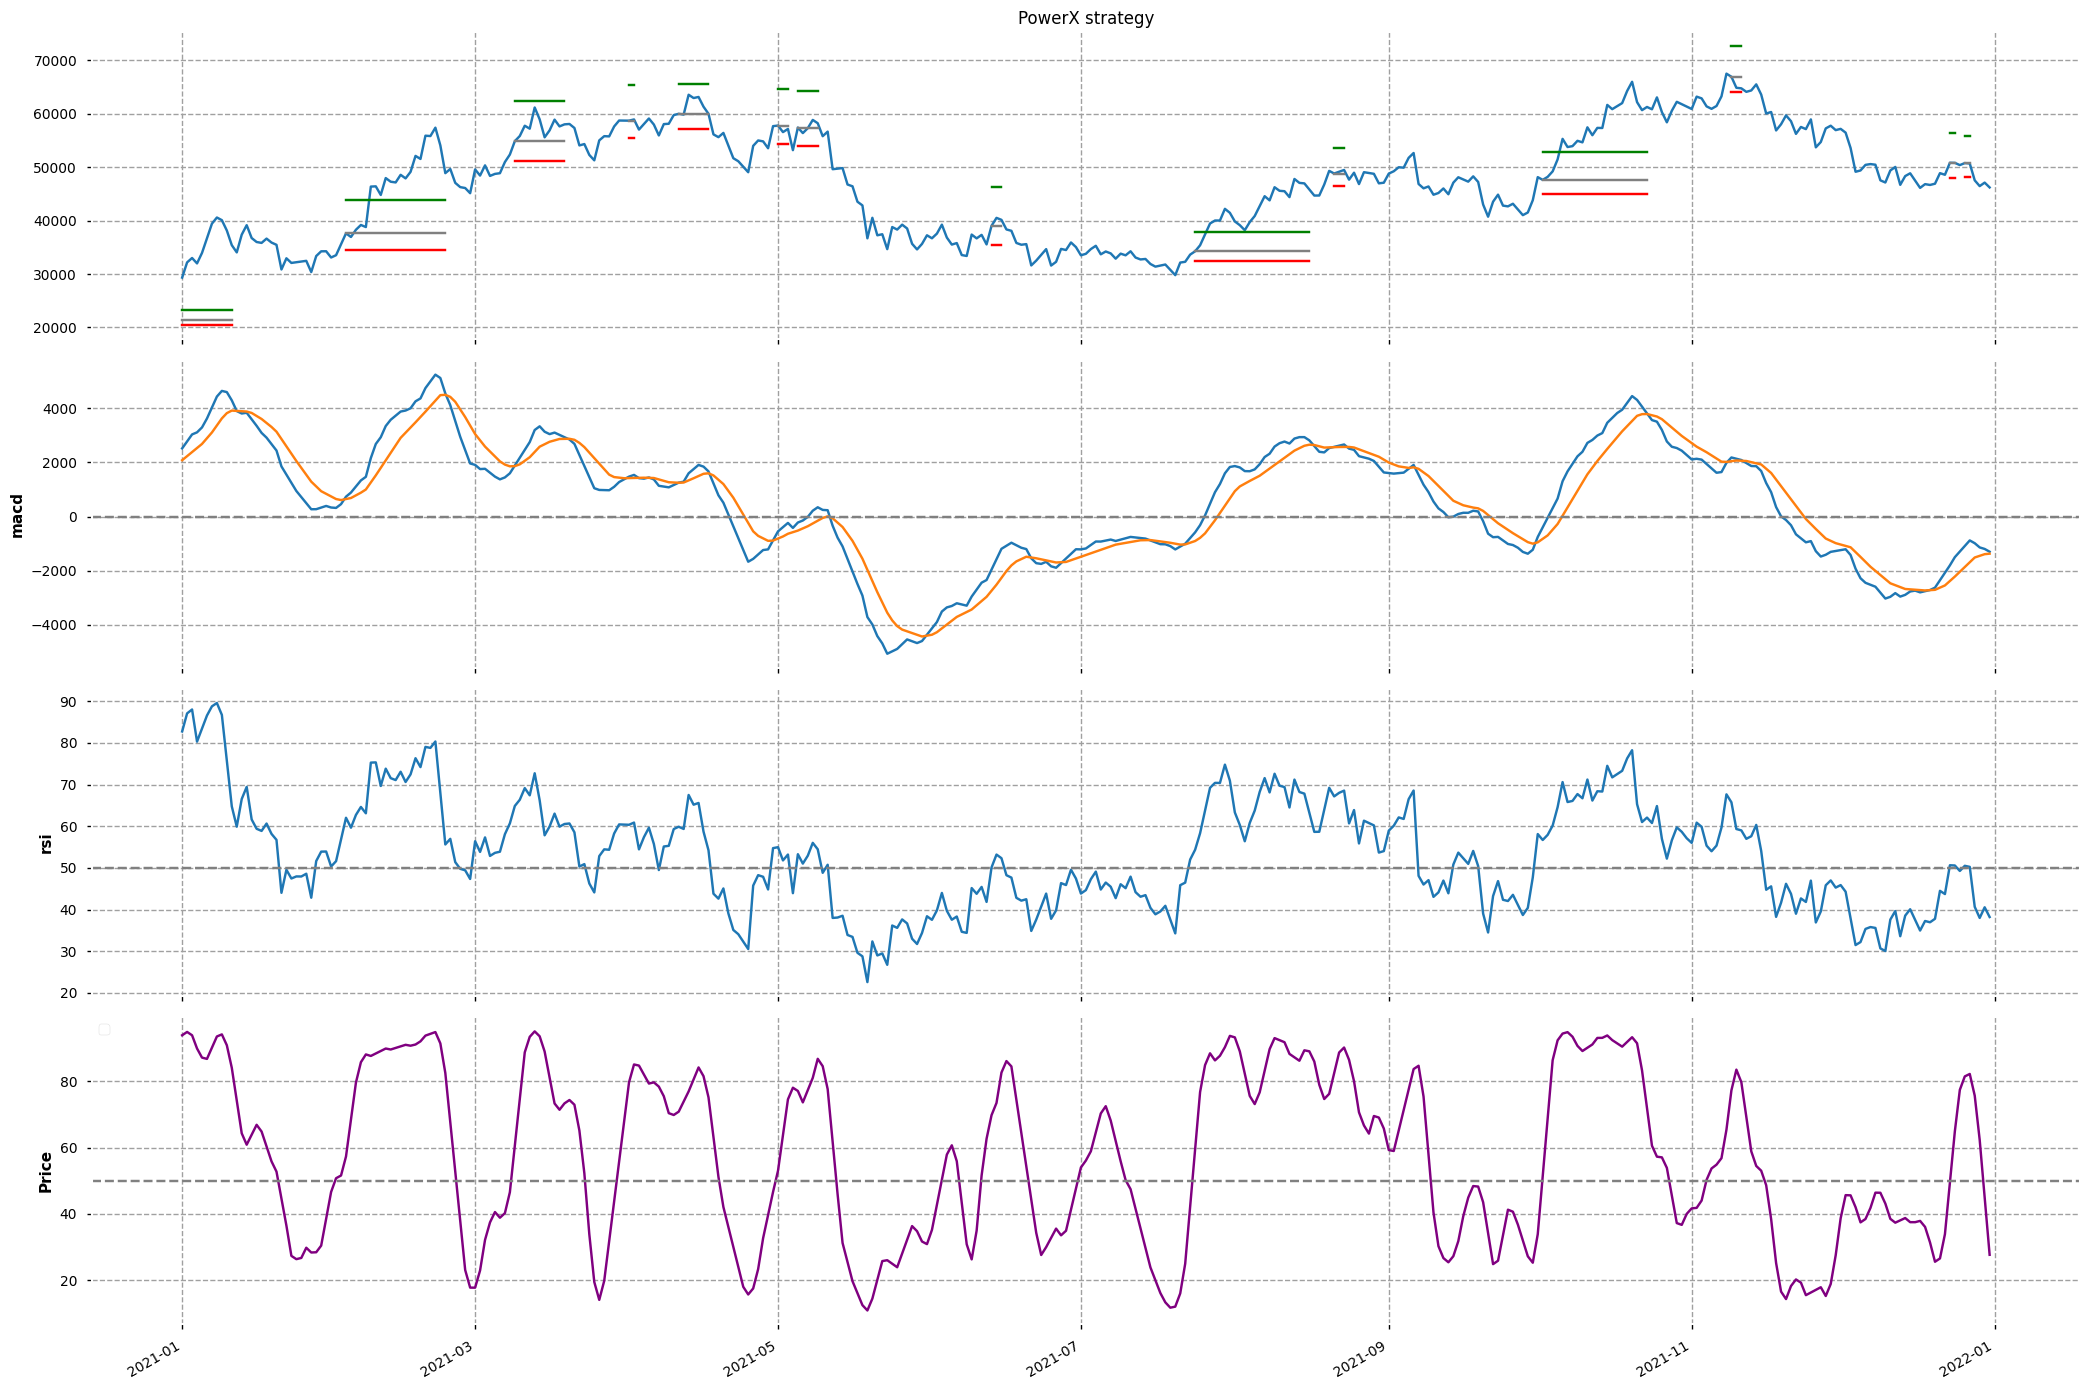

In [184]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn-notebook')
plt.figure(figsize=(21,14))

days = 365
dates = df['date'].tail(days)
price = df['close'].tail(days)
buyprice = df['buyprice'].tail(days)
stoploss = df['stoploss'].tail(days)
takeprofit = df['takeprofit'].tail(days)
slowd_level = 50
rsi_level = 50
macd = df['macd'].tail(days)
macd_signal = df['macdsignal'].tail(days)
slowd = df['slowd'].tail(days)
rsi = df['rsi'].tail(days)

plt.subplot(4, 1, 1)
plt.plot_date(dates, price, linestyle='solid', marker=None, label='BTC price')
plt.plot(dates, buyprice, label='buyprice', color='grey')
plt.plot(dates, stoploss, label='stoploss', color='red')
plt.plot(dates, takeprofit, label='takeprofit', color='green')
plt.title('PowerX strategy')
plt.xlabel('Date')

plt.subplot(4, 1, 2)
plt.plot(dates, macd, label='macd', alpha=1)
plt.plot(dates, macd_signal, label='signal', alpha=1)
plt.axhline(y=0, color='grey', linestyle='--')
# plt.xlabel('Date')
plt.ylabel('macd')

plt.subplot(4, 1, 3)
plt.plot(dates, rsi)
plt.axhline(y=50, color='grey', linestyle='--')
# plt.xlabel('Date')
plt.ylabel('rsi')

plt.subplot(4, 1, 4)
plt.plot(dates, slowd, color='purple')
plt.axhline(y=50, color='grey', linestyle='--')
# plt.xlabel('Date')
plt.ylabel('slowd')


plt.gcf().autofmt_xdate()

plt.ylabel('Price')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
